# Load modules

In [1]:
import re
import emoji
import time
import string
import os
import pickle

import torch
from tqdm.notebook import tqdm
import nltk

from transformers import BertTokenizer
from torch.utils.data import TensorDataset, DataLoader

from transformers import BertForSequenceClassification

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load dataset for subjective data

In [2]:
# Load reddit dataset
sarcasm_df = pd.read_csv('sarcasm.csv', usecols=['comment', 'label', 'subreddit'])

sarcasm_df.head()

,label,comment,subreddit
0,0,NC and NH.,politics
1,0,You do know west teams play against west teams...,nba
2,0,"They were underdogs earlier today, but since G...",nfl
3,0,"This meme isn't funny none of the ""new york ni...",BlackPeopleTwitter
4,0,I could use one of those tools.,MaddenUltimateTeam


In [3]:
sarcasm_df.isnull().sum()

label         0
comment      55
subreddit     0
dtype: int64

In [4]:
# Drop null
sarcasm_df = sarcasm_df.dropna()
sarcasm_df.isnull().sum()

label        0
comment      0
subreddit    0
dtype: int64

In [32]:
# Select relevant subreddits to use
# subreddits = ['technology', 'MachineLearning']
# df = sarcasm_df[sarcasm_df.subreddit.isin(subreddits)].reset_index(drop=True)
# df = sarcasm_df.sample(50000, random_state=11)
# df.describe(include='all')

,label,comment,subreddit
count,50000.000000,50000,50000
unique,NaN,49060,4123
top,NaN,You forgot the,AskReddit
freq,NaN,70,3279
mean,0.498420,NaN,NaN
std,0.500003,NaN,NaN
min,0.000000,NaN,NaN
25%,0.000000,NaN,NaN
50%,0.000000,NaN,NaN
75%,1.000000,NaN,NaN


In [95]:
# Mix subreddits with those that we want
# Note that this dataset is generated in 2017, so most of the gen AI subreddits have not existed
subreddits = ['technology', 'MachineLearning']

mask = sarcasm_df.subreddit.isin(subreddits)
tech_df = sarcasm_df[mask].reset_index(drop=True)
other_df = sarcasm_df[~mask].reset_index(drop=True)
tech_df.shape

(5720, 3)

In [99]:
N = 50000 - len(tech_df)
df = sarcasm_df.sample(N, random_state=11)
df = pd.concat([df, tech_df])
df = df.sample(frac=1).reset_index(drop=True)      # Shuffle rows
df.describe(include='all')

,label,comment,subreddit
count,50000.000000,50000,50000
unique,NaN,48842,3887
top,NaN,You forgot the,technology
freq,NaN,78,5928
mean,0.511260,NaN,NaN
std,0.499878,NaN,NaN
min,0.000000,NaN,NaN
25%,0.000000,NaN,NaN
50%,1.000000,NaN,NaN
75%,1.000000,NaN,NaN


In [100]:
# Rename comment column
df = df.rename(columns={"comment": "sentence"})
df.drop(columns=['subreddit'], inplace=True)
df.head()

,label,sentence
0,0,My friends in San Marco said they have no floo...
1,1,My guess is on the parade reaching Waveland...
2,0,Huk's Mothership rush back in the day
3,0,"""You can't mirror mirrored items and all uniqu..."
4,0,"Take a look at Edward Snowden's case, and you ..."


# Process data

In [101]:
def remove_not_ASCII(text):
    text = str(text)
    text = ''.join([word for word in text if word in string.printable])
#     print(text)
    return text

def replace_emoticons(text):
    text = text.replace("<3", "heart ")
    text = re.sub('>:-?\'?"?\(+', 'angry ', text)
    text = re.sub('\)+:-?\'?"?:<', 'angry ', text)
    text = re.sub(':-?\'?"?(o+|O+|0+)', 'surprised ', text)
    text = re.sub(':-?\'?"?(\)+|>+|D+)', 'smile ', text)
    text = re.sub('(\(+|<+)-?\'?"?:', 'smile ', text)
    text = re.sub(':-?\'?"?\(+', 'sad ', text)
    text = re.sub('(\)+|>+|D+)-?\'?"?:', 'sad ', text)
    
    return text

def text_preprocessing(text):
    # Clean dataset
    text = replace_emoticons(text)                           # convert emoticon to text
    text = emoji.demojize(text, delimiters=("", " "))        # convert emoji to text
    text = remove_not_ASCII(text)                            # remove non-ASCII characters

    text = re.sub('<br />', '', text)                        # remove <br />
    text = re.sub('^https?:\/\/S+', '', text)                # remove URLs
    
    text = re.sub('u/\S+', 'user', text)                     # replace user mentions
    text = re.sub('@\S+', 'user', text)
    text = re.sub('r/\S+', 'subreddit', text)                # replace subreddit mentions
    return text


In [102]:
df['sentence'] = df['sentence'].apply(text_preprocessing)
df.head()

,label,sentence
0,0,My friends in San Marco said they have no floo...
1,1,My guess is on the parade reaching Waveland...
2,0,Huk's Mothership rush back in the day
3,0,"""You can't mirror mirrored items and all uniqu..."
4,0,"Take a look at Edward Snowden's case, and you ..."


In [103]:
df['label'].value_counts()

label
1    25563
0    24437
Name: count, dtype: int64

In [104]:
possible_labels = df.label.unique()

label_dict = {}
for index, possible_label in enumerate(possible_labels):
    label_dict[possible_label] = index
label_dict

{0: 0, 1: 1}

In [105]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(df.index.values, 
                                                  df.label.values, 
                                                  test_size=0.2, 
                                                  random_state=11, 
                                                  stratify=df.label.values)


In [106]:
df['data_type'] = ['not_set']*df.shape[0]

df.loc[X_train, 'data_type'] = 'train'
df.loc[X_val, 'data_type'] = 'val'


In [107]:
df.groupby(['label', 'data_type']).count()

sentence
label data_type          
0     train         19550
      val            4887
1     train         20450
      val            5113

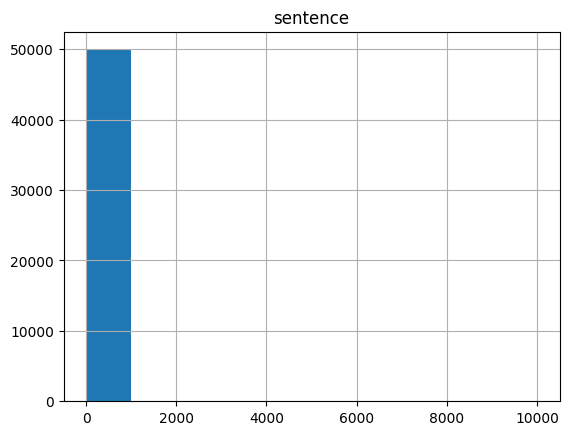

,sentence
count,50000.000000
mean,57.962420
std,75.391402
min,1.000000
25%,27.000000
50%,47.000000
75%,76.000000
max,10000.000000


In [108]:
# Determine value of max_seq_len
review_len = pd.DataFrame(df['sentence'].apply(len))
review_len.hist()
plt.show()
review_len.describe()

# Encode data

In [109]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', 
                                          do_lower_case=True)

In [110]:
encoded_data_train = tokenizer.batch_encode_plus(
    df[df.data_type=='train'].sentence.values, 
    add_special_tokens=True, 
    return_attention_mask=True, 
    pad_to_max_length=True, 
    max_length=256, 
    return_tensors='pt'
)

encoded_data_val = tokenizer.batch_encode_plus(
    df[df.data_type=='val'].sentence.values, 
    add_special_tokens=True, 
    return_attention_mask=True, 
    pad_to_max_length=True, 
    max_length=256, 
    return_tensors='pt'
)

input_ids_train = encoded_data_train['input_ids']
attention_masks_train = encoded_data_train['attention_mask']
labels_train = torch.tensor(df[df.data_type=='train'].label.values)

input_ids_val = encoded_data_val['input_ids']
attention_masks_val = encoded_data_val['attention_mask']
labels_val = torch.tensor(df[df.data_type=='val'].label.values)


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/home/FYP/c200129/.conda/envs/test/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:2645: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [111]:
dataset_train = TensorDataset(input_ids_train, attention_masks_train, labels_train)
dataset_val = TensorDataset(input_ids_val, attention_masks_val, labels_val)


In [112]:
len(dataset_train), len(dataset_val)

(40000, 10000)

In [113]:
model = BertForSequenceClassification.from_pretrained("bert-base-uncased",
                                                      num_labels=len(label_dict),
                                                      output_attentions=False,
                                                      output_hidden_states=False)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [114]:
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

batch_size = 32

dataloader_train = DataLoader(dataset_train, 
                              sampler=RandomSampler(dataset_train), 
                              batch_size=batch_size)

dataloader_validation = DataLoader(dataset_val, 
                                   sampler=SequentialSampler(dataset_val), 
                                   batch_size=batch_size)


In [115]:
from transformers import AdamW, get_linear_schedule_with_warmup

optimizer = AdamW(model.parameters(),
                  lr=1e-5, 
                  eps=1e-8)

/home/FYP/c200129/.conda/envs/test/lib/python3.10/site-packages/transformers/optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [116]:
# Using Early stopper to stop when the F1 Score prediction drops 
class EarlyStopper:
    def __init__(self, patience=3, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.min_f1_score = 0
        self.min_accuracy = 0

    def early_stop_f1(self, f1_score):
        if f1_score > self.min_f1_score:
            self.min_f1_score = f1_score
            self.counter = 0
        elif f1_score <= (self.min_f1_score + self.min_delta):
            self.counter += 1
            if self.counter >= self.patience:
                self.counter = 0
                self.f1_score = 0
                return True
        return False

    def early_stop_accuracy(self, accuracy):
        if accuracy > self.min_accuracy:
            self.min_accuracy = accuracy
            self.counter = 0
        elif accuracy < (self.min_accuracy + self.min_delta):
            self.counter += 1
            if self.counter >= self.patience:
                self.counter = 0
                self.min_accuracy = 0
                return True
        return False

# Train Model

In [117]:
epochs = 25

scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps=0,
                                            num_training_steps=len(dataloader_train)*epochs)


In [118]:
from sklearn.metrics import f1_score

def f1_score_func(preds, labels):
    preds_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return f1_score(labels_flat, preds_flat, average='weighted')

def accuracy_per_class(preds, labels):
    label_dict_inverse = {v: k for k, v in label_dict.items()}
    
    preds_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    
    total_preds = 0
    total_correct = 0

    for label in np.unique(labels_flat):
        y_preds = preds_flat[labels_flat==label]
        y_true = labels_flat[labels_flat==label]
        
        total_preds += len(y_preds)
        num_correct = len(y_preds[y_preds==label])
        total_correct += num_correct
        acc = num_correct/len(y_true)
        
        print(f'Class: {label_dict_inverse[label]}')
        print(f'Accuracy: {acc}')
        print(f'Accuracy (in percentage): {acc*100:.3f}\n')
    
    print(f'Total accuracy: {(total_correct/total_preds)*100:.3f}')


In [119]:
import random

seed_val = 11
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

In [120]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

print(device)

cuda


In [121]:
def evaluate(dataloader_val):

    model.eval()
    
    loss_val_total = 0
    predictions, true_vals = [], []
    
    for batch in dataloader_val:
        
        batch = tuple(b.to(device) for b in batch)
        
        inputs = {'input_ids':      batch[0],
                  'attention_mask': batch[1],
                  'labels':         batch[2],
                 }

        with torch.no_grad():        
            outputs = model(**inputs)
            
        loss = outputs[0]
        logits = outputs[1]
        loss_val_total += loss.item()

        logits = logits.detach().cpu().numpy()
        label_ids = inputs['labels'].cpu().numpy()
        predictions.append(logits)
        true_vals.append(label_ids)
    
    loss_val_avg = loss_val_total/len(dataloader_val) 
    
    predictions = np.concatenate(predictions, axis=0)
    true_vals = np.concatenate(true_vals, axis=0)
            
    return loss_val_avg, predictions, true_vals

In [ ]:
early_stopper = EarlyStopper(patience=3, min_delta=0)

e = 0

for epoch in tqdm(range(1, epochs+1)):
    
    model.train()
    
    loss_train_total = 0

    progress_bar = tqdm(dataloader_train, desc='Epoch {:1d}'.format(epoch), leave=False, disable=False)
    
    for batch in progress_bar:
        model.zero_grad()

        batch = tuple(b.to(device) for b in batch)
        
        inputs = {'input_ids':      batch[0],
                  'attention_mask': batch[1],
                  'labels':         batch[2],
                 }       

        outputs = model(**inputs)
        
        loss = outputs[0]
        loss_train_total += loss.item()
        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        optimizer.step()
        scheduler.step()
        
        progress_bar.set_postfix({'training_loss': '{:.3f}'.format(loss.item()/len(batch))})
              
    tqdm.write(f'\nEpoch {epoch}')
    
    loss_train_avg = loss_train_total/len(dataloader_train)            
    tqdm.write(f'Training loss: {loss_train_avg}')
    
    val_loss, predictions, true_vals = evaluate(dataloader_validation)
    val_f1 = f1_score_func(predictions, true_vals)
    tqdm.write(f'Validation loss: {val_loss}')
    tqdm.write(f'F1 Score (Weighted): {val_f1}')
    
    # Check for early stop
    if early_stopper and early_stopper.early_stop_f1(val_f1):
        e = epoch
        print(f"Early stopping at epoch {epoch} due to no improvement in f1 score.")
        torch.save(model.state_dict(), f'finetuned_BERT_sarcasm_mixed_epoch_{e}.model')
        break

  0%|          | 0/25 [00:00<?, ?it/s]

Epoch 1:   0%|          | 0/1250 [00:00<?, ?it/s]


Epoch 1
Training loss: 0.5806402681350707
Validation loss: 0.5349455054004353
F1 Score (Weighted): 0.7315498762634955


Epoch 2:   0%|          | 0/1250 [00:00<?, ?it/s]

# Test model and get accuracy

In [56]:
model = BertForSequenceClassification.from_pretrained("bert-base-uncased",
                                                      num_labels=len(label_dict),
                                                      output_attentions=False,
                                                      output_hidden_states=False)

model.to(device)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

In [57]:
model.load_state_dict(torch.load(f'finetuned_BERT_sarcasm_mixed_epoch_{e}.model', map_location=torch.device('cuda')))
print('Model loaded, getting predictions...')
_, predictions, true_vals = evaluate(dataloader_validation)
accuracy_per_class(predictions, true_vals)
f1_score = f1_score_func(predictions, true_vals)
print(f'F1 score: {f1_score:.3f}')

Model loaded, getting predictions...
Class: 0
Accuracy: 0.6674641148325359
Accuracy (in percentage): 66.746

Class: 1
Accuracy: 0.7656500802568218
Accuracy (in percentage): 76.565

Total accuracy: 71.640
F1 score: 0.7157349193136776


In [58]:
print(e)

5


# Test with custom data

In [37]:
model.load_state_dict(torch.load(f'finetuned_BERT_sarcasm_epoch_{e}.model', map_location=torch.device('cuda')))

text = input("Enter some text: ")
text = text_preprocessing(text)

encoded_text = tokenizer.encode_plus(
    text, 
    add_special_tokens=True, 
    return_attention_mask=True, 
    pad_to_max_length=True, 
    max_length=256, 
    return_tensors='pt'
)
# print(encoded_text)

input_ids_text = encoded_text['input_ids']
attention_masks_text = encoded_text['attention_mask']

dataset = TensorDataset(input_ids_text, attention_masks_text)
dataloader = DataLoader(dataset, 
                        sampler=RandomSampler(dataset), 
                        batch_size=1)

for batch in dataloader:
    batch = tuple(b.to(device) for b in batch)
    inputs = {'input_ids':      batch[0],
              'attention_mask': batch[1]
             }

    with torch.no_grad():        
        outputs = model(**inputs)
        logits = outputs[0]
        logits = logits.detach().cpu().numpy()

#     print(logits)
    pred = np.argmax(logits, axis=1).flatten()[0]
    print(f'Prediction: {list(label_dict.keys())[pred]}')


Enter some text: wow
Prediction: 1
